<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/05_mnist_nice_son.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.datasets import load_digits
from sklearn.datasets import make_moons

In [78]:
class Data(Dataset):
    def __init__(self, dataset):
        super(Data, self).__init__()

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset.data[idx]
        y = self.dataset.targets[idx]
        return x, y

In [79]:
class NICE(nn.Module):
    def __init__(self, input_dim, hidden_layer, num_flows=2):
        super(NICE, self).__init__()

        self.input_dim = input_dim
        self.hidden_layer = hidden_layer
        self.num_flows = num_flows

        self.net = lambda : nn.Sequential(
                                 nn.Linear(self.input_dim//2, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.input_dim//2)) # input dimension must be equal to output dimension

        self.m = nn.ModuleList([self.net() for _ in range(self.num_flows)])

        self.s = nn.Parameter(torch.rand(input_dim), requires_grad=True)


    def forward(self, x):
        x = x[0].to(torch.float32)
        x = x.view(len(x), -1,) / 255
        return self.f(x)

    def coupling_layer(self, x, m, flow, forward=True):
        x = x.clone()

        x_a = x[:, ::2] if flow%2==0 else x[:, 1::2]
        x_b = x[:, 1::2] if flow%2==0 else x[:, ::2]

        if forward:
            y_b = (x_b - m(x_a))
        else:
            y_b = (x_b + m(x_a))

        #z = torch.concat((x_a, y_b), axis=1) if flow%2==0 else torch.concat((y_b, x_a), axis=1)
        z = torch.empty(x.shape)
        z[:, ::2] = x_a if flow%2==0 else y_b
        z[:, 1::2] = y_b if flow%2==0 else x_a
        return z


    def f(self, x):
        z = x

        for flow, model in enumerate(self.m, start=0):
            z = self.coupling_layer(z, model, flow, forward=True)

        z = z * torch.exp(self.s)
        log_det_j = self.s.reshape(-1,1)

        return z, log_det_j

    def f_inv(self, z):
        x = z / torch.exp(self.s)

        for flow, model in reversed(list(enumerate(self.m, start=0))):
            x = self.coupling_layer(x, model, flow,forward=False)

        return x

    def criterion(self, z, prior, log_det_j, reduction = "sum"):

        if reduction == "sum":
            loss = - (prior.log_prob(z) + log_det_j).sum()
        else:

            loss = - (prior.log_prob(z) + log_det_j).mean()
        return loss

In [80]:
train_image = torchvision.datasets.MNIST(root='dataset', train=True, download=True, transform=transforms.ToTensor())
test_image = torchvision.datasets.MNIST(root='dataset', train=False, download=True, transform=transforms.ToTensor())



train_data = Data(train_image)
test_data = Data(test_image)

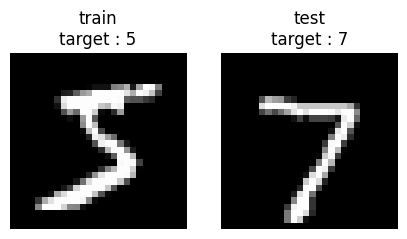

In [81]:
image_train, category_train = train_data[0]
image_test, category_test = test_data[0]


plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(image_train.reshape((28,28)), cmap='gray')
plt.title(f'train\ntarget : {category_train}')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(image_test.reshape((28,28)), cmap='gray')
plt.title(f'test\ntarget : {category_test}')
plt.axis('off')

plt.show()

In [82]:
data_dim = 28*28
prior = torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.zeros((data_dim)),
                                                    scale_tril=torch.diag(torch.ones((data_dim))))

model = NICE(input_dim=data_dim, hidden_layer=128, num_flows=10)

train_loader = DataLoader(train_data, batch_size=5000, shuffle=True)


In [83]:
epochs = 50
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

COST = []

for epoch in range(epochs):
    total_loss = []

    for x in train_loader:

        z, log_det_j = model.forward(x)
        loss = model.criterion(z, prior, log_det_j, reduction="avg")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    COST.append(np.mean(total_loss))

    if epoch==0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))
    elif (epoch+1)%1 == 0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))

Epoch :  1   -----------> Loss :  834.3680318196615
Epoch :  2   -----------> Loss :  801.185557047526
Epoch :  3   -----------> Loss :  794.4869333902994
Epoch :  4   -----------> Loss :  787.672861735026
Epoch :  5   -----------> Loss :  780.6893870035807
Epoch :  6   -----------> Loss :  775.0283711751302
Epoch :  7   -----------> Loss :  770.8338419596354
Epoch :  8   -----------> Loss :  766.3595581054688
Epoch :  9   -----------> Loss :  762.7120717366537
Epoch :  10   -----------> Loss :  759.3325754801432
Epoch :  11   -----------> Loss :  756.9101816813151
Epoch :  12   -----------> Loss :  754.7771911621094
Epoch :  13   -----------> Loss :  752.8216400146484
Epoch :  14   -----------> Loss :  751.3327992757162
Epoch :  15   -----------> Loss :  749.7316640218099
Epoch :  16   -----------> Loss :  748.3982645670573
Epoch :  17   -----------> Loss :  747.3009897867838
Epoch :  18   -----------> Loss :  746.1557057698568
Epoch :  19   -----------> Loss :  746.5932362874349
Epoc

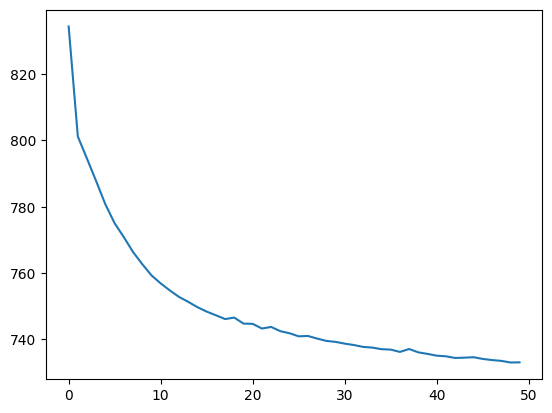

In [84]:
plt.plot(COST)

In [85]:
test = prior.sample((50,))
test

tensor([[ 1.4928,  0.6012, -2.7425,  ..., -1.5245,  0.8679,  0.3261],
        [ 1.1075,  0.2419, -0.4010,  ...,  0.8686,  0.0075, -1.2090],
        [-0.0788, -1.5979,  0.8521,  ..., -0.0888, -1.3250, -0.2661],
        ...,
        [-1.2836, -0.2963,  0.0607,  ..., -1.3686, -0.9210,  0.3472],
        [ 1.0311,  0.1968, -0.1344,  ..., -1.3322, -1.0571,  0.4807],
        [ 0.4619,  1.8518,  0.5773,  ..., -0.2651,  1.8548, -0.5016]])

In [86]:
sonuc = model.f_inv(test)


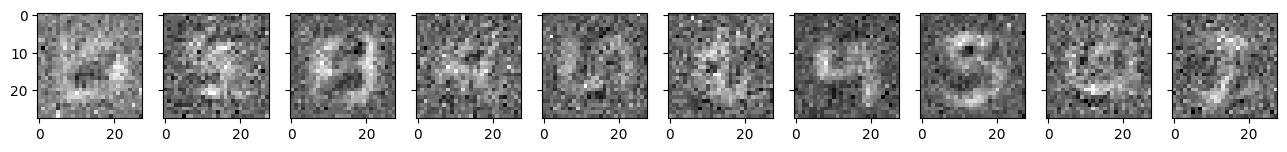

In [87]:
test = prior.sample((10,))
sonuc = model.f_inv(test)

fig, axs = plt.subplots(1, 10, sharex=True, sharey=True, figsize=(16, 8))

for i in range(0,10):

    axs[i].imshow(sonuc[i].detach().numpy().reshape((28,28)), cmap='gray')
    #axs[i].axis('off')

fig.show()